In [4]:
import torch
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import pandas as pd
import os
from torchvision import datasets
from torch.utils.data import DataLoader
from PIL import Image

In [2]:
#Load ImageNet pre-trained ViT
model_name = 'google/vit-base-patch16-224-in21k' #Model version

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = 4,
    problem_type="multi_label_classification"
) 

# Feature extractor for preprocessing images
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
class ViTDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)  # Load image and label
        image = feature_extractor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)  # Apply feature extractor
        return image, label


# DATASET.

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/covid19-radiography-database


In [5]:
#Read dataset.
data_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID"

# List files inside the original dataset
files = os.listdir(data_path)
print("Files in dataset:", files)


Files in dataset: ['images', 'masks']


In [6]:
import shutil
import random
from pathlib import Path

# Define the dataset paths
DATASET_PATH = "//kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset"
OUTPUT_DIR = "/kaggle/working/covid_split"

TRAIN_DIR = os.path.join(OUTPUT_DIR, "train")
VAL_DIR = os.path.join(OUTPUT_DIR, "val")
TEST_DIR = os.path.join(OUTPUT_DIR, "test")

# Define class names (each folder contains "images" and "mask" subfolders)
CLASSES = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]

# Function to create directories
def create_dirs():
    for split in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
        for cls in CLASSES:
            os.makedirs(os.path.join(split, cls), exist_ok=True)

create_dirs()

# Function to split and copy images
def split_data(source_folder, class_name, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    image_folder = os.path.join(source_folder, "images")  # Target "images" subfolder
    image_files = list(Path(image_folder).glob("*.png"))  # Get all image files
    
    random.shuffle(image_files)  # Shuffle for randomness
    
    train_count = int(len(image_files) * train_ratio)
    val_count = int(len(image_files) * val_ratio)
    
    train_files = image_files[:train_count]
    val_files = image_files[train_count:train_count + val_count]
    test_files = image_files[train_count + val_count:]

    # Copy images to train, val, and test folders
    for file in train_files:
        shutil.copy(file, os.path.join(TRAIN_DIR, class_name, file.name))
    
    for file in val_files:
        shutil.copy(file, os.path.join(VAL_DIR, class_name, file.name))
    
    for file in test_files:
        shutil.copy(file, os.path.join(TEST_DIR, class_name, file.name))

# Process each class folder
for cls in CLASSES:
    source_path = os.path.join(DATASET_PATH, cls)  # Main folder for each class
    split_data(source_path, cls)

# Verify the split
for split in ["train", "val", "test"]:
    for cls in CLASSES:
        path = os.path.join(OUTPUT_DIR, split, cls)
        print(f"{split}/{cls}: {len(os.listdir(path))} images")


train/COVID: 3275 images
train/Lung_Opacity: 5454 images
train/Normal: 9295 images
train/Viral Pneumonia: 1229 images
val/COVID: 993 images
val/Lung_Opacity: 1660 images
val/Normal: 2834 images
val/Viral Pneumonia: 379 images
test/COVID: 984 images
test/Lung_Opacity: 1664 images
test/Normal: 2836 images
test/Viral Pneumonia: 375 images


Image 1 | Class: Normal | Shape: (299, 299, 3)
Image 2 | Class: Normal | Shape: (299, 299, 3)
Image 3 | Class: COVID | Shape: (299, 299, 3)
Image 4 | Class: Normal | Shape: (299, 299, 3)
Image 5 | Class: COVID | Shape: (299, 299, 3)


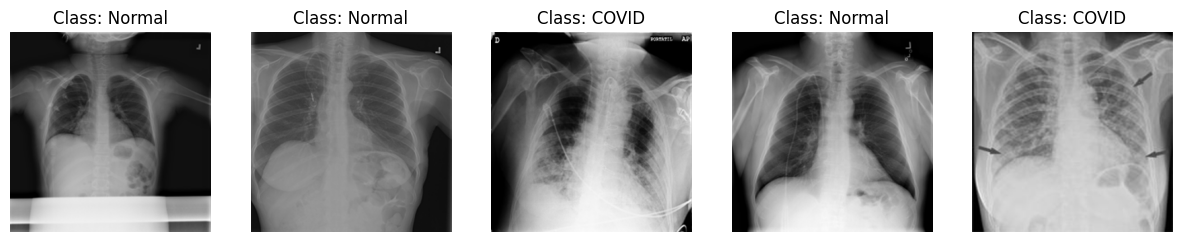

In [7]:
import matplotlib.pyplot as plt
import cv2
import random
from glob import glob

# Define dataset path (update with 'train', 'val', or 'test')
dataset_path = "/kaggle/working/covid_split/train"  

# Get all image file paths from subdirectories
image_files = glob(os.path.join(dataset_path, "*/*.png")) 

# Randomly select 5 images
num_images = 5
selected_images = random.sample(image_files, num_images)  # Random sampling

# Create plot
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)  
    class_name = os.path.basename(os.path.dirname(img_path))  # Extract class from folder name

    print(f"Image {i+1} | Class: {class_name} | Shape: {img.shape}")  # Print class & shape

    # Show image
    axes[i].imshow(img, cmap="gray")  
    axes[i].set_title(f"Class: {class_name}") 
    axes[i].axis("off")

plt.show()

In [8]:
# Define dataset paths
train_dir = "/kaggle/working/covid_split/train"
val_dir = "/kaggle/working/covid_split/val"
test_dir = "/kaggle/working/covid_split/test"

# Load datasets
train_dataset = ViTDataset(root=train_dir)
val_dataset = ViTDataset(root=val_dir)
test_dataset = ViTDataset(root=test_dir)

# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Check batch shape
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels}")


Batch shape: torch.Size([32, 3, 224, 224]), Labels: tensor([1, 1, 2, 2, 0, 1, 1, 3, 2, 2, 2, 2, 0, 2, 2, 3, 1, 2, 2, 2, 1, 2, 3, 0,
        2, 1, 2, 0, 1, 1, 1, 2])


# TRAIN.

In [9]:
def train(model, train_loader, optimizer, criterion, device, scheduler=None):
    total_correct = 0.0
    total_loss = 0.0
    batch_loss = 0.0
    batch_correct = 0.0

    model.train()
    for idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        output = model(inputs).logits  
        
        # Calculate loss
        loss = criterion(output, labels)
        loss.backward()
        
        # Calculate accuracy
        correct = (output.argmax(dim=1) == labels).sum().item()
        
        # Accumulate total correct and total loss
        total_correct += correct
        total_loss += loss.item()

        # Batch statistics for logging
        batch_correct += correct
        batch_loss += loss.item()

        optimizer.step()

        if (idx + 1) % 100 == 0:
            # Print out the average loss and accuracy every 100 batches
            print(f"Batch {idx + 1}: Average Loss {batch_loss / 100:.4f} | Average Accuracy {batch_correct / (100 * len(labels)) * 100:.2f}%")
            batch_correct = 0.0
            batch_loss = 0.0

        
        if scheduler is not None:
            scheduler.step()
    
    # Return the average accuracy and loss for the entire dataset
    avg_accuracy = total_correct / len(train_loader.dataset)
    avg_loss = total_loss / len(train_loader)
    return avg_accuracy, avg_loss


In [10]:
LR = 2e-05
EPOCHS = 15

In [11]:
import torch.nn as nn
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.995)
device = "cuda"

In [12]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [13]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_correct = 0.0
    total_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            
            logits = output.logits
            
            # Calculate loss
            loss = criterion(logits, labels)
            total_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_loss += loss.item()

    accuracy = total_correct / len(test_loader.dataset)
    loss = total_loss / len(test_loader)
    
    return accuracy, loss


In [14]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def run(model, train_loader, validation_loader, test_loader, optimizer, criterion, device, scheduler=None):
    current_patience = 0
    previous_valid_loss = None
    best_valid_loss = None
    
    # Initialize lists to store the losses for plotting
    train_losses = []
    valid_losses = []
    test_losses = []

    for epoch in tqdm(range(EPOCHS)):
        print("==================================================")
        print(f"EPOCH {epoch + 1}")
        train_accuracy, train_loss = train(model, train_loader, optimizer, criterion, device, scheduler=None)
        print(f"[TRAIN] EPOCH {epoch + 1} - LOSS: {train_loss}, ACCURACY: {train_accuracy}")
        validation_accuracy, validation_loss = evaluate(model, validation_loader, criterion, device)
        print(f"[VALIDATE] EPOCH {epoch + 1} - LOSS: {validation_loss}, ACCURACY: {validation_accuracy}")
        print("==================================================")
        test_accuracy, test_loss = evaluate(model, test_loader, criterion, device)
        print(f"[TEST] EPOCH {epoch + 1} - LOSS: {test_loss}, ACCURACY: {test_accuracy}")
        print("==================================================")

        # Store the losses for plotting later
        train_losses.append(train_loss)
        valid_losses.append(validation_loss)
        test_losses.append(test_loss)

        # First iteration
        if best_valid_loss is None and previous_valid_loss is None:
            best_valid_loss = validation_loss
            model.save_pretrained('/kaggle/working/doctorViT')
            previous_valid_loss = validation_loss
            continue
        # Early stopping
        if validation_loss >= previous_valid_loss:
            current_patience += 1
            if current_patience >= 5:
                print("Early Stop")
                break
            previous_valid_loss = validation_loss

        # Save best model
        if validation_loss <= best_valid_loss:
            model.save_pretrained('/kaggle/working/doctorViT_bestVal')
            best_valid_loss = validation_loss
            patience = 0

    # Plot the losses 
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
    plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training, Validation and Test Loss Over Epochs')
    plt.legend()
    plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH 1
Batch 100: Average Loss 0.8148 | Average Accuracy 71.56%
Batch 200: Average Loss 0.4023 | Average Accuracy 89.31%
Batch 300: Average Loss 0.2916 | Average Accuracy 92.25%
Batch 400: Average Loss 0.2438 | Average Accuracy 93.38%
Batch 500: Average Loss 0.2157 | Average Accuracy 93.75%
Batch 600: Average Loss 0.2221 | Average Accuracy 93.06%
[TRAIN] EPOCH 1 - LOSS: 0.36421479896156495, ACCURACY: 0.8891081909312835
[VALIDATE] EPOCH 1 - LOSS: 0.18744397677643143, ACCURACY: 0.9457892942379816
[TEST] EPOCH 1 - LOSS: 0.1923440028913319, ACCURACY: 0.9460658815497525


  7%|▋         | 1/15 [12:54<3:00:41, 774.38s/it]

EPOCH 2
Batch 100: Average Loss 0.1650 | Average Accuracy 95.16%
Batch 200: Average Loss 0.1484 | Average Accuracy 95.94%
Batch 300: Average Loss 0.1701 | Average Accuracy 95.03%
Batch 400: Average Loss 0.1462 | Average Accuracy 95.84%
Batch 500: Average Loss 0.1639 | Average Accuracy 95.03%
Batch 600: Average Loss 0.1469 | Average Accuracy 95.41%
[TRAIN] EPOCH 2 - LOSS: 0.15712876460728456, ACCURACY: 0.953773437905781
[VALIDATE] EPOCH 2 - LOSS: 0.12487050911168689, ACCURACY: 0.9604500511421753
[TEST] EPOCH 2 - LOSS: 0.12644354614388684, ACCURACY: 0.961768219832736


 13%|█▎        | 2/15 [25:58<2:48:59, 779.94s/it]

EPOCH 3
Batch 100: Average Loss 0.1146 | Average Accuracy 96.62%
Batch 200: Average Loss 0.1056 | Average Accuracy 96.75%
Batch 300: Average Loss 0.1040 | Average Accuracy 97.16%
Batch 400: Average Loss 0.1155 | Average Accuracy 96.91%
Batch 500: Average Loss 0.1088 | Average Accuracy 96.69%
Batch 600: Average Loss 0.1112 | Average Accuracy 96.72%
[TRAIN] EPOCH 3 - LOSS: 0.10988850649631894, ACCURACY: 0.9681088661507298
[VALIDATE] EPOCH 3 - LOSS: 0.09577256009873489, ACCURACY: 0.9722127514490283
[TEST] EPOCH 3 - LOSS: 0.10477890501446697, ACCURACY: 0.9708141321044547


 20%|██        | 3/15 [39:01<2:36:16, 781.37s/it]

EPOCH 4
Batch 100: Average Loss 0.0707 | Average Accuracy 98.25%
Batch 200: Average Loss 0.0709 | Average Accuracy 98.16%
Batch 300: Average Loss 0.0675 | Average Accuracy 98.12%
Batch 400: Average Loss 0.0675 | Average Accuracy 98.03%
Batch 500: Average Loss 0.0796 | Average Accuracy 97.75%
Batch 600: Average Loss 0.0948 | Average Accuracy 97.06%
[TRAIN] EPOCH 4 - LOSS: 0.0753414007538057, ACCURACY: 0.9789123772918507
[VALIDATE] EPOCH 4 - LOSS: 0.09582921908662209, ACCURACY: 0.9713603818615751


 27%|██▋       | 4/15 [52:03<2:23:17, 781.60s/it]

[TEST] EPOCH 4 - LOSS: 0.10242904430133817, ACCURACY: 0.9685953234340331
EPOCH 5
Batch 100: Average Loss 0.0422 | Average Accuracy 98.94%
Batch 200: Average Loss 0.0451 | Average Accuracy 98.97%
Batch 300: Average Loss 0.0525 | Average Accuracy 98.41%
Batch 400: Average Loss 0.0585 | Average Accuracy 98.47%
Batch 500: Average Loss 0.0501 | Average Accuracy 98.75%
Batch 600: Average Loss 0.0473 | Average Accuracy 98.78%
[TRAIN] EPOCH 5 - LOSS: 0.049525821353293385, ACCURACY: 0.9871188905625098
[VALIDATE] EPOCH 5 - LOSS: 0.08297888780488512, ACCURACY: 0.9752812819638595
[TEST] EPOCH 5 - LOSS: 0.09621007174870971, ACCURACY: 0.9720088752346817


 33%|███▎      | 5/15 [1:05:06<2:10:21, 782.18s/it]

EPOCH 6
Batch 100: Average Loss 0.0315 | Average Accuracy 99.22%
Batch 200: Average Loss 0.0264 | Average Accuracy 99.47%
Batch 300: Average Loss 0.0663 | Average Accuracy 97.78%
Batch 400: Average Loss 0.0594 | Average Accuracy 98.16%
Batch 500: Average Loss 0.0295 | Average Accuracy 99.22%
Batch 600: Average Loss 0.0449 | Average Accuracy 98.75%
[TRAIN] EPOCH 6 - LOSS: 0.042921517784568014, ACCURACY: 0.9876902300940114
[VALIDATE] EPOCH 6 - LOSS: 0.07228786857930296, ACCURACY: 0.9809069212410502
[TEST] EPOCH 6 - LOSS: 0.07690887245268602, ACCURACY: 0.9779825908858167


 40%|████      | 6/15 [1:18:09<1:57:23, 782.61s/it]

EPOCH 7
Batch 100: Average Loss 0.0317 | Average Accuracy 99.16%
Batch 200: Average Loss 0.0308 | Average Accuracy 99.16%
Batch 300: Average Loss 0.0379 | Average Accuracy 98.72%
Batch 400: Average Loss 0.0189 | Average Accuracy 99.69%
Batch 500: Average Loss 0.0274 | Average Accuracy 99.41%
Batch 600: Average Loss 0.0223 | Average Accuracy 99.53%
[TRAIN] EPOCH 7 - LOSS: 0.028098567599350234, ACCURACY: 0.9927803459201163
[VALIDATE] EPOCH 7 - LOSS: 0.06271758462737678, ACCURACY: 0.984145925673372
[TEST] EPOCH 7 - LOSS: 0.06634445343946066, ACCURACY: 0.9827615634067247


 47%|████▋     | 7/15 [1:31:12<1:44:20, 782.53s/it]

EPOCH 8
Batch 100: Average Loss 0.0249 | Average Accuracy 99.31%
Batch 200: Average Loss 0.0263 | Average Accuracy 99.38%
Batch 300: Average Loss 0.0290 | Average Accuracy 99.28%
Batch 400: Average Loss 0.0209 | Average Accuracy 99.44%
Batch 500: Average Loss 0.0221 | Average Accuracy 99.53%
Batch 600: Average Loss 0.0163 | Average Accuracy 99.59%
[TRAIN] EPOCH 8 - LOSS: 0.02322508333145681, ACCURACY: 0.9942346647275749
[VALIDATE] EPOCH 8 - LOSS: 0.06565403816690062, ACCURACY: 0.984145925673372


 53%|█████▎    | 8/15 [1:44:13<1:31:14, 782.03s/it]

[TEST] EPOCH 8 - LOSS: 0.07641206442950414, ACCURACY: 0.9824202082266599
EPOCH 9
Batch 100: Average Loss 0.0144 | Average Accuracy 99.56%
Batch 200: Average Loss 0.0232 | Average Accuracy 99.28%
Batch 300: Average Loss 0.0157 | Average Accuracy 99.59%
Batch 400: Average Loss 0.0255 | Average Accuracy 99.12%
Batch 500: Average Loss 0.0247 | Average Accuracy 99.25%
Batch 600: Average Loss 0.0126 | Average Accuracy 99.75%
[TRAIN] EPOCH 9 - LOSS: 0.019290401400732144, ACCURACY: 0.9942866046849842
[VALIDATE] EPOCH 9 - LOSS: 0.07672781843702188, ACCURACY: 0.9821002386634845


 60%|██████    | 9/15 [1:57:14<1:18:10, 781.78s/it]

[TEST] EPOCH 9 - LOSS: 0.08032538141908488, ACCURACY: 0.9813961426864652
EPOCH 10
Batch 100: Average Loss 0.0124 | Average Accuracy 99.66%
Batch 200: Average Loss 0.0113 | Average Accuracy 99.69%
Batch 300: Average Loss 0.0213 | Average Accuracy 99.28%
Batch 400: Average Loss 0.0195 | Average Accuracy 99.41%
Batch 500: Average Loss 0.0216 | Average Accuracy 99.44%
Batch 600: Average Loss 0.0131 | Average Accuracy 99.75%
[TRAIN] EPOCH 10 - LOSS: 0.016767136617045403, ACCURACY: 0.9953254038331688
[VALIDATE] EPOCH 10 - LOSS: 0.0696114981312902, ACCURACY: 0.9839754517558813


 67%|██████▋   | 10/15 [2:10:16<1:05:09, 781.82s/it]

[TEST] EPOCH 10 - LOSS: 0.0763766750587029, ACCURACY: 0.9819081754565625
EPOCH 11
Batch 100: Average Loss 0.0225 | Average Accuracy 99.41%
Batch 200: Average Loss 0.0160 | Average Accuracy 99.62%
Batch 300: Average Loss 0.0083 | Average Accuracy 99.75%
Batch 400: Average Loss 0.0142 | Average Accuracy 99.56%
Batch 500: Average Loss 0.0152 | Average Accuracy 99.50%
Batch 600: Average Loss 0.0359 | Average Accuracy 99.03%
[TRAIN] EPOCH 11 - LOSS: 0.01864261140364634, ACCURACY: 0.9948060042590765
[VALIDATE] EPOCH 11 - LOSS: 0.06591220555065261, ACCURACY: 0.9822707125809751


 73%|███████▎  | 11/15 [2:23:18<52:07, 781.90s/it]  

[TEST] EPOCH 11 - LOSS: 0.06658215100026649, ACCURACY: 0.9836149513568868
EPOCH 12
Batch 100: Average Loss 0.0050 | Average Accuracy 99.91%
Batch 200: Average Loss 0.0065 | Average Accuracy 99.91%
Batch 300: Average Loss 0.0036 | Average Accuracy 99.91%
Batch 400: Average Loss 0.0181 | Average Accuracy 99.44%
Batch 500: Average Loss 0.0160 | Average Accuracy 99.44%
Batch 600: Average Loss 0.0188 | Average Accuracy 99.28%
[TRAIN] EPOCH 12 - LOSS: 0.01130649803204004, ACCURACY: 0.9964680828961721
[VALIDATE] EPOCH 12 - LOSS: 0.0755439482397734, ACCURACY: 0.9805659734060689


 80%|████████  | 12/15 [2:36:19<39:04, 781.65s/it]

[TEST] EPOCH 12 - LOSS: 0.077563991279812, ACCURACY: 0.9791773340160437
EPOCH 13
Batch 100: Average Loss 0.0055 | Average Accuracy 99.88%
Batch 200: Average Loss 0.0025 | Average Accuracy 99.97%
Batch 300: Average Loss 0.0073 | Average Accuracy 99.75%
Batch 400: Average Loss 0.0149 | Average Accuracy 99.50%
Batch 500: Average Loss 0.0345 | Average Accuracy 98.88%
Batch 600: Average Loss 0.0221 | Average Accuracy 99.16%
[TRAIN] EPOCH 13 - LOSS: 0.01442098496120154, ACCURACY: 0.9952215239183504
[VALIDATE] EPOCH 13 - LOSS: 0.07635998581637345, ACCURACY: 0.9810773951585408


 87%|████████▋ | 13/15 [2:49:22<26:03, 781.97s/it]

[TEST] EPOCH 13 - LOSS: 0.07848621527512517, ACCURACY: 0.9815668202764977
EPOCH 14
Batch 100: Average Loss 0.0074 | Average Accuracy 99.84%
Batch 200: Average Loss 0.0067 | Average Accuracy 99.81%
Batch 300: Average Loss 0.0084 | Average Accuracy 99.75%
Batch 400: Average Loss 0.0047 | Average Accuracy 99.84%
Batch 500: Average Loss 0.0075 | Average Accuracy 99.81%
Batch 600: Average Loss 0.0036 | Average Accuracy 99.94%
[TRAIN] EPOCH 14 - LOSS: 0.006368313708626495, ACCURACY: 0.9983379213629044
[VALIDATE] EPOCH 14 - LOSS: 0.07164327534005481, ACCURACY: 0.9855097170132969


 93%|█████████▎| 14/15 [3:02:24<13:02, 782.13s/it]

[TEST] EPOCH 14 - LOSS: 0.07173468409113727, ACCURACY: 0.9851510496671787
EPOCH 15
Batch 100: Average Loss 0.0012 | Average Accuracy 100.00%
Batch 200: Average Loss 0.0013 | Average Accuracy 100.00%
Batch 300: Average Loss 0.0016 | Average Accuracy 99.97%
Batch 400: Average Loss 0.0137 | Average Accuracy 99.53%
Batch 500: Average Loss 0.0073 | Average Accuracy 99.78%
Batch 600: Average Loss 0.0044 | Average Accuracy 99.88%
[TRAIN] EPOCH 15 - LOSS: 0.004883343153331503, ACCURACY: 0.9985976211499507
[VALIDATE] EPOCH 15 - LOSS: 0.07560886933820059, ACCURACY: 0.9856801909307876


100%|██████████| 15/15 [3:15:26<00:00, 781.80s/it]

[TEST] EPOCH 15 - LOSS: 0.07746526239150073, ACCURACY: 0.9853217272572111


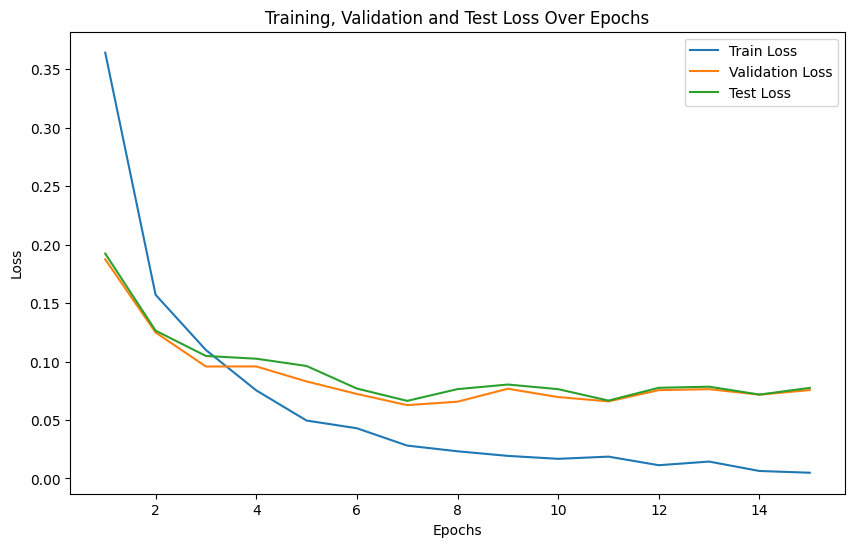

In [15]:
run(model, train_loader, val_loader, test_loader, optimizer, criterion, device, scheduler)